# &nbsp; Supervised ML: Predicting housing prices (Phase1: Classification)
- Iteration 1: Train a decision tree
- Iteration 2: grid search

**Challenge overview:**

The goal of this project is creating a model that predicts the price of a house based on its characteristics. This project has 2 phase:
1. Create a model to predict whether a house is expensive or not. 
2. Create a model to predict the exact price of a house.

In this notebook, we work on the first phase with the goal to build a model, which have a categorical target: “Expensive” and “Not expensive”. 

## 0.&nbsp; Understanding the datasets

**Dataset variables:**

*   LotArea --> Lot size in square feet
*   LotFrontage  -->  Linear feet of street connected to property
*   TotalBsmtSF  -->  Total square feet of basement area
*   BedroomAbvGr -->  Bedrooms above grade (does NOT include basement bedrooms)
*   Fireplaces   -->  Number of fireplaces
*   PoolArea     -->  Pool area in square feet
*   GarageCars   -->  Size of garage in car capacity
*   WoodDeckSF   -->  Wood deck area in square feet
*   ScreenPorch  -->  Screen porch area in square feet

## 1.&nbsp; Data reading & first glance

In [1]:
import pandas as pd

url = "https://drive.google.com/file/d/1zkZ8eScWgUgXwNLsUbFisNX1IEb1YxbF/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

housing_data = pd.read_csv(path)

In [2]:
housing_data.sample(3)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
1131,10712,63.0,974,3,0,0,0,0,0,0
1066,7837,59.0,799,3,1,0,2,0,0,0
727,7314,64.0,1232,2,0,0,2,132,0,0


Just look briefly at the data types of your columns get an idea of how they look like.

In [3]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       1460 non-null   int64  
 1   LotFrontage   1201 non-null   float64
 2   TotalBsmtSF   1460 non-null   int64  
 3   BedroomAbvGr  1460 non-null   int64  
 4   Fireplaces    1460 non-null   int64  
 5   PoolArea      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   WoodDeckSF    1460 non-null   int64  
 8   ScreenPorch   1460 non-null   int64  
 9   Expensive     1460 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 114.2 KB


## 2.&nbsp; Data preprocessing

### 2.1.&nbsp; Set X and y

- **X**: The "feature columns" that help us make a prediction is denoted as `X`. Some of the columns in the original dataset are not useful when it comes to finding patterns in the data. So, the first step when building our `X`, the vector of predictor features, is to drop them.
- **y**: The "target column" that we want to predict is usually denoted as `y` and we call it a `label`. We will "pop" it out from the rest of the data.

In [4]:
X = housing_data.drop(columns=["WoodDeckSF", "ScreenPorch"])
y = X.pop("Expensive")

Even if the target (`y`) and the features (`X`) are in two different objects, there is still a very easy mapping between them: the first row in `X` and the first element in `y` both correspond to the first house, the second row in `X`and the second element in `y` correspond to the second house, and so on.

### 2.2.&nbsp; Data cleaning and/or feature selection

In [5]:
X.isna().sum()

LotArea           0
LotFrontage     259
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
dtype: int64

We will impute missing values of ``LotFrontage`` column later!

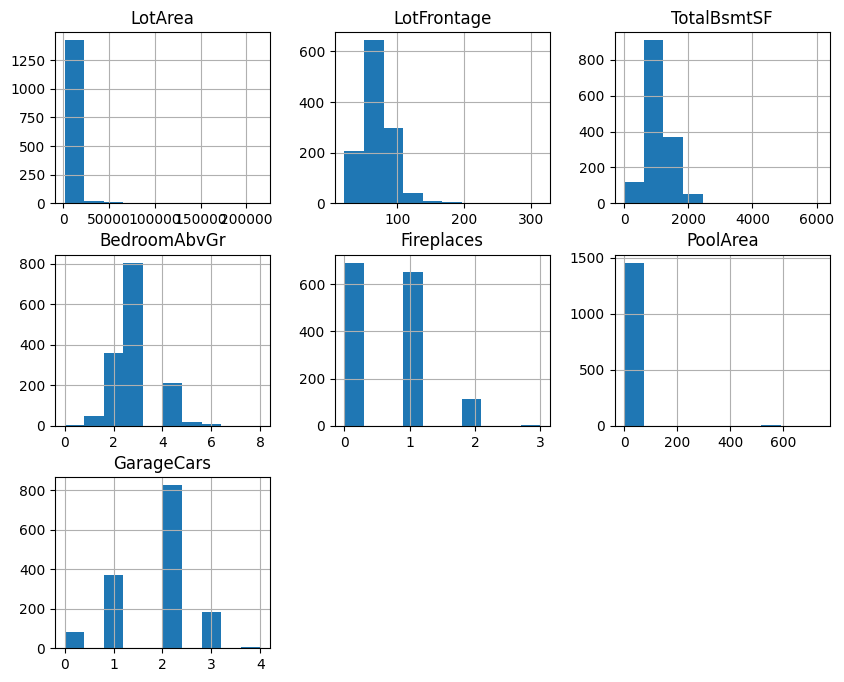

In [6]:
X.hist(figsize=(10, 8));

### 2.3.&nbsp; Train-test split

Before performing a deeper exploration, we will split the dataset into 2 chunks: train and test. We will use the train set to find patterns in the data and create a model. The test set will remain untouched, unseen, unexplored. It will be the "reality check" for our model, it will let us know whether our model is able to generalize.

Here, we're using the function `train_test_split` to shuffle the observations randomly and create the train and test sets for both the `X` and the `y` objects at the same time, ensuring that they are shuffled the same way:

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=123)

In [9]:
X_train.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars
318,9900,90.0,1347,4,1,0,3
580,14585,NaN,1144,3,2,0,2
961,12227,NaN,1330,4,1,0,2
78,10778,72.0,1768,4,0,0,0
5,14115,85.0,796,1,0,0,2


In [10]:
y_train.head()

318    1
580    0
961    1
78     0
5      0
Name: Expensive, dtype: int64

As you can see from the indices, both the `X` and `y` train sets contain first the house in position `318`, then the one in position `580`, etc.

The same applies for the test set:

In [11]:
X_test.head(2)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars
147,9505,NaN,884,3,1,0,2
676,9600,60.0,1095,4,0,0,3


In [12]:
y_test.head(2)

147    0
676    0
Name: Expensive, dtype: int64

### 2.4.&nbsp; Dealing with missing data

For various reasons, many real world datasets contain missing values, often encoded as blanks, NaNs or other placeholders. Such datasets however are incompatible with **some** scikit-learn estimators which assume that all values in an array are numerical, and that all have and hold meaning. **Most** machine learning algorithms require that their inputs have no missing values, and will not work if this requirement is violated.
For more details on estimators that handle NaN values in the new versions of SK-Learn, take a look here: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [13]:
import sklearn
sklearn. __version__

'1.6.0'

### 2.4.1.&nbsp; Impute missing values

A basic strategy in order to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data.
We will use the `SimpleImputer()` with its default values. It will replace any missing value with the mean of the column it belongs to.

Simple imputer allows these strategies:
- mean (default),
- median,
- most frequent,
- constant.

For more details, look here: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [14]:
X_train.isna().sum()

LotArea           0
LotFrontage     189
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
dtype: int64

In [15]:
X_test.isna().sum()

LotArea          0
LotFrontage     70
TotalBsmtSF      0
BedroomAbvGr     0
Fireplaces       0
PoolArea         0
GarageCars       0
dtype: int64

In [16]:
from sklearn.impute import SimpleImputer

Follow this approach for different types of estimators:
1. initialize,
2. use fit on the **train** set,
3. use transform on the **train** set,
4. use transform on the **test** set.

It is possible to combine steps 2 and 3 and use fit_transform instead.

The **.fit() method** is used to learn parameters from the training data. For example, an imputer learns statistical measures (like mean or median) from the training data to impute missing values.

The **.transform() method** applies the learned transformation (imputation, scaling, etc.) to new data. It does not learn anything new; it simply applies the transformations based on the parameters learned during .fit().

NO DATA SNOOPING! **Do not fit to both train, test and do not transform test before train data.**


In [17]:
# 1. initialize
my_imputer = SimpleImputer().set_output(transform='pandas')

# 2. use fit on the train set
my_imputer.fit(X_train)

# 3. use transform on the train set
X_imputed_train = my_imputer.transform(X_train)

In [18]:
X_imputed_train.isnull().sum()

LotArea         0
LotFrontage     0
TotalBsmtSF     0
BedroomAbvGr    0
Fireplaces      0
PoolArea        0
GarageCars      0
dtype: int64

In [19]:
# 4. impute NaN's to test set
X_imputed_test = my_imputer.transform(X_test)

In [20]:
X_imputed_test.isnull().sum()

LotArea         0
LotFrontage     0
TotalBsmtSF     0
BedroomAbvGr    0
Fireplaces      0
PoolArea        0
GarageCars      0
dtype: int64

## 3.&nbsp; Modelling: Implement a Decision Tree

#### Pros and Cons, Step-by-step, Example:

1. Pros and Cons
- **Helpful for feature selection**: Can tell us which features are most important for differentiating target classes 🧩.
- **"White box"**: We can see and understand exactly how a decision tree works 🔍.
- **Does automatic feature selection**: Reduces the amount of preprocessing required ⚙️.
- **Struggles with**: Linear relationships, highly correlated features, outliers, highly imbalanced data.

2. How does it work (Step-by-step)
- **Starting Point**: Begin with the entire dataset and choose a feature to split the data based on some criterion
- **Splitting**: Select the feature that best separates classes, then split the data into these classes.
- **Recursion**: Repeat the process for each subset, for all relevant features.
- **Stopping Criteria**:  Recursion stops if *maximum depth* is reached, all samples belong to the *same class* or *no further improvement* can be made.
- **Leaf Nodes**: Assigned to the class that is most common among the samples in that node.


3. Example: Will this customer purchase my luxury watch?

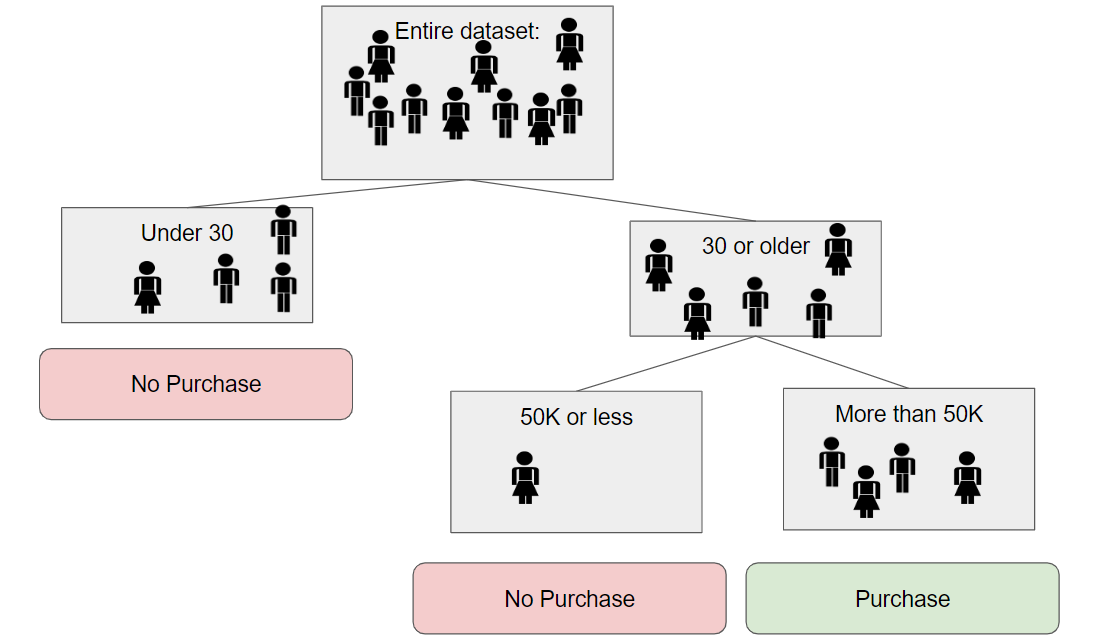


A Decision Tree is one of the simplest Machine Learning models. To implement it, we need to first:

- Import it from the appropriate submodule of Scikit-Learn.
- Initialize it.
- Fit it.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [21]:
# 1. import the model
from sklearn.tree import DecisionTreeClassifier

Initialize the model.

In [22]:
# 2. initialize the model (optional: give some parameters)
my_tree = DecisionTreeClassifier()

Fit the model to the train data.

In [23]:
# 3. fit the model to the train data
my_tree.fit(X = X_imputed_train,
            y = y_train)

DecisionTreeClassifier()

### 3.1.&nbsp; Make predictions and check accuracy on the train set

In [24]:
# make predictions
y_pred_tree_train = my_tree.predict(X_imputed_train)

**.predict() method**: you pass in the input data (X_num_imputed_train) for which you want to predict the target variable (or class labels).

In [25]:
# Check accuracy on the train set
from sklearn.metrics import accuracy_score

accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train
              )

1.0

The model seems to work REALLY well. Suspiciously well, even. Remember that the model has been trained using the train set and we have now checked its accuracy on the very same train set. The real evaluation will come from the test set.

### 3.2.&nbsp; Check accuracy for the test set

Is the model able to generalize? Is it able to make predictions on data it has not "seen" before?

To check whether our model is only good at predicting the values it was trained on (overfitting) or also useful to predict new data:

use the model and the preprocessed **test** data to make predictions.

In [26]:
y_pred_tree_test = my_tree.predict(X_imputed_test)

Then, take the predicted values and the data from y test, and compare them with each other.

Ideally, the accuracy for the train and the test data is similar.

In [27]:
accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test
              )

0.8938356164383562

Our model has a **high variance**: the difference between train and test set is huge. We can also say that our model suffers from **overfitting**: it has captured patterns in the training set that were not present in the testing set (they were mere "noise").

We will need to improve the model but before that let's see what the Decision Tree looks like.

### 3.3.&nbsp; Plotting the Decision Tree

A Decision Tree is a succession of rules that split the dataset based on the variables that better predict the target. This tree, with its rules, can be visualized in a diagram:

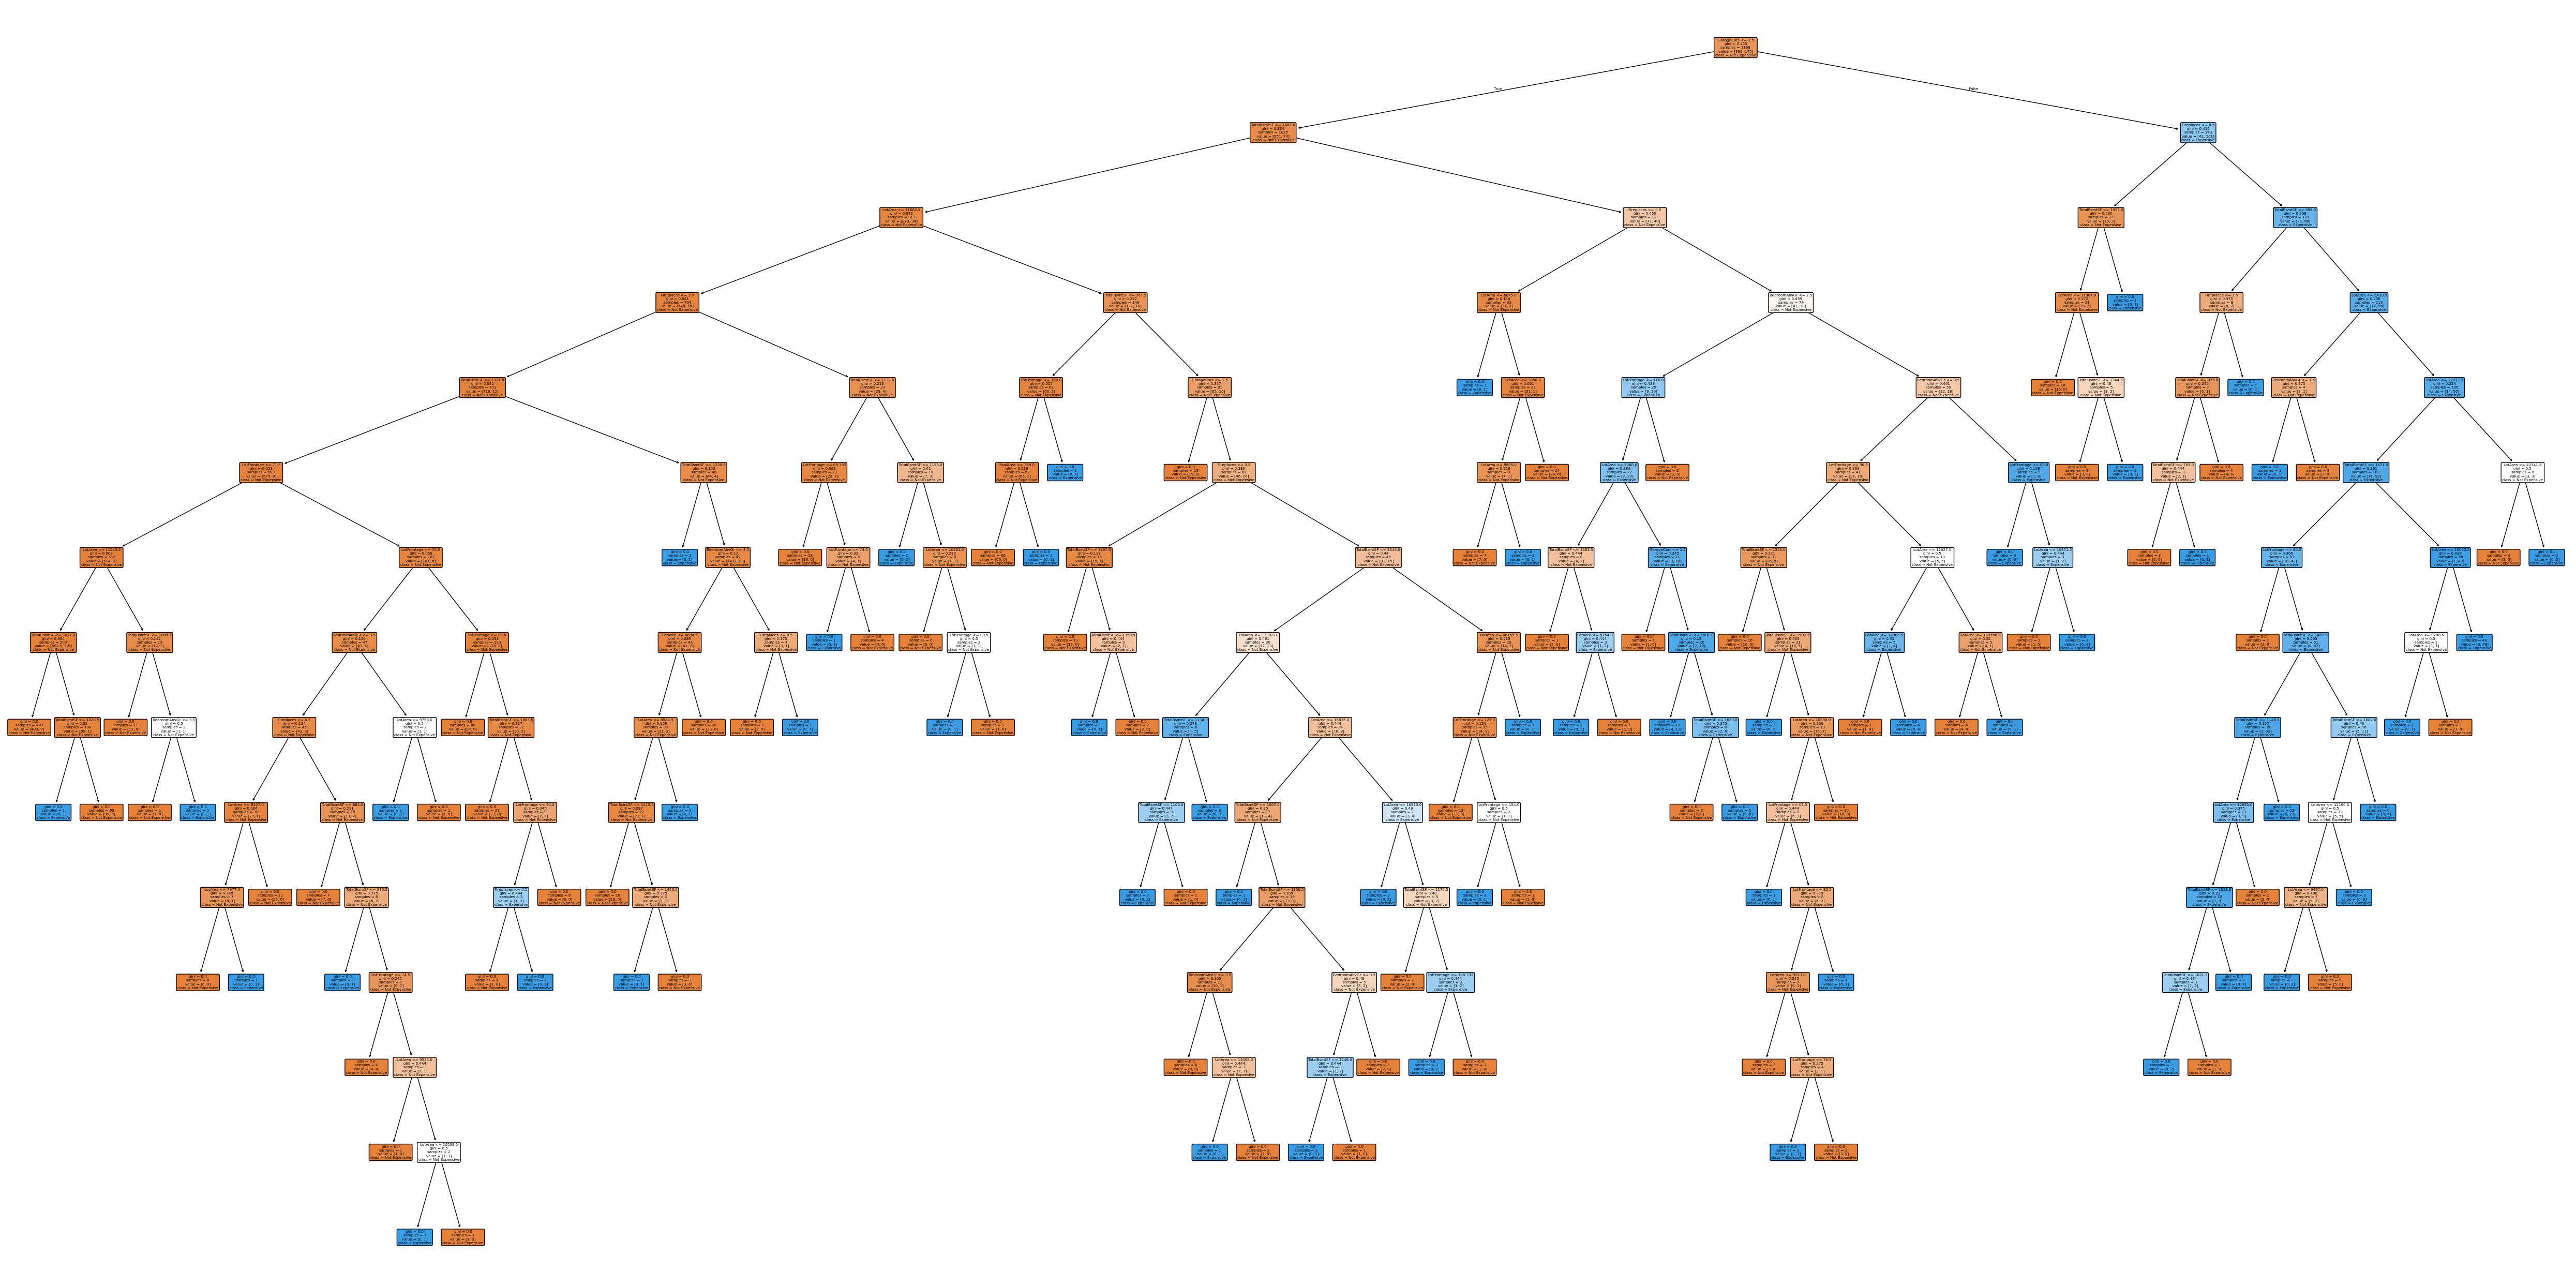

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(64, 32))

plot_tree(
    my_tree,                          # Decision tree model to visualize
    filled=True,                      # Whether to fill nodes with colors based on majority class
    rounded=True,                     # Whether to round the corners of the nodes
    class_names=['Not Expensive','Expensive'],  # Names of the classes for the target variable
    feature_names=X.columns       # Names of the features (columns) in your dataset
);


Our current tree is too big to distinguish what's going on. It has dozens, maybe hundreds of rules. In other words, our model is **very complex**, which is a common characteristic of models that suffer from overfitting.

To reduce the complexity (the size) of the tree and prevent overfitting, we can play with the hyperparameters of the tree. It's a process known as "pruning" the tree.

### 3.4.&nbsp; Pruning the tree

We can tweak the parameters `max_depth` and `min_samples_leaf` of the decision tree, based on the Scikit-Learn documentation, to make the tree smaller. 

Major hyperparameters:

- **max_depth**: Limits the size of the decision tree. Larger numbers lead to overfitting. A range of **2-15** is reasonable depending on the complexity of the problem and the number of features in the dataset. It can be more if the problem is highly complex.
- **min_samples_leaf**: Requires that any pattern apply to at least this many points in the training data. Higher numbers reduce overfitting. The range should be based on the size and diversity of the dataset. Try a range from **5-30** or so.
- **criterion**: Determines how the algorithm evaluates the best splits to make at each decision node. Try all three.
- **min_impurity_decrease**: Sets the standard for how effective a split must be, limiting the complexity of the model and reducing overfitting when the number is higher. A reasonable range can be from **0 to 0.5** but should generally be closer to **0.1**.
- **ccp_alpha**: Prunes the completed decision tree, removing parts that increase complexity without significantly improving purity. A reasonable range is from **0 to 0.1**.

In [29]:
X_imputed_prune_train = X_imputed_train.copy()
y_prune_train = y_train.copy()
X_prune_imputed_test = X_imputed_test.copy()
y_prune_test = y_test.copy()

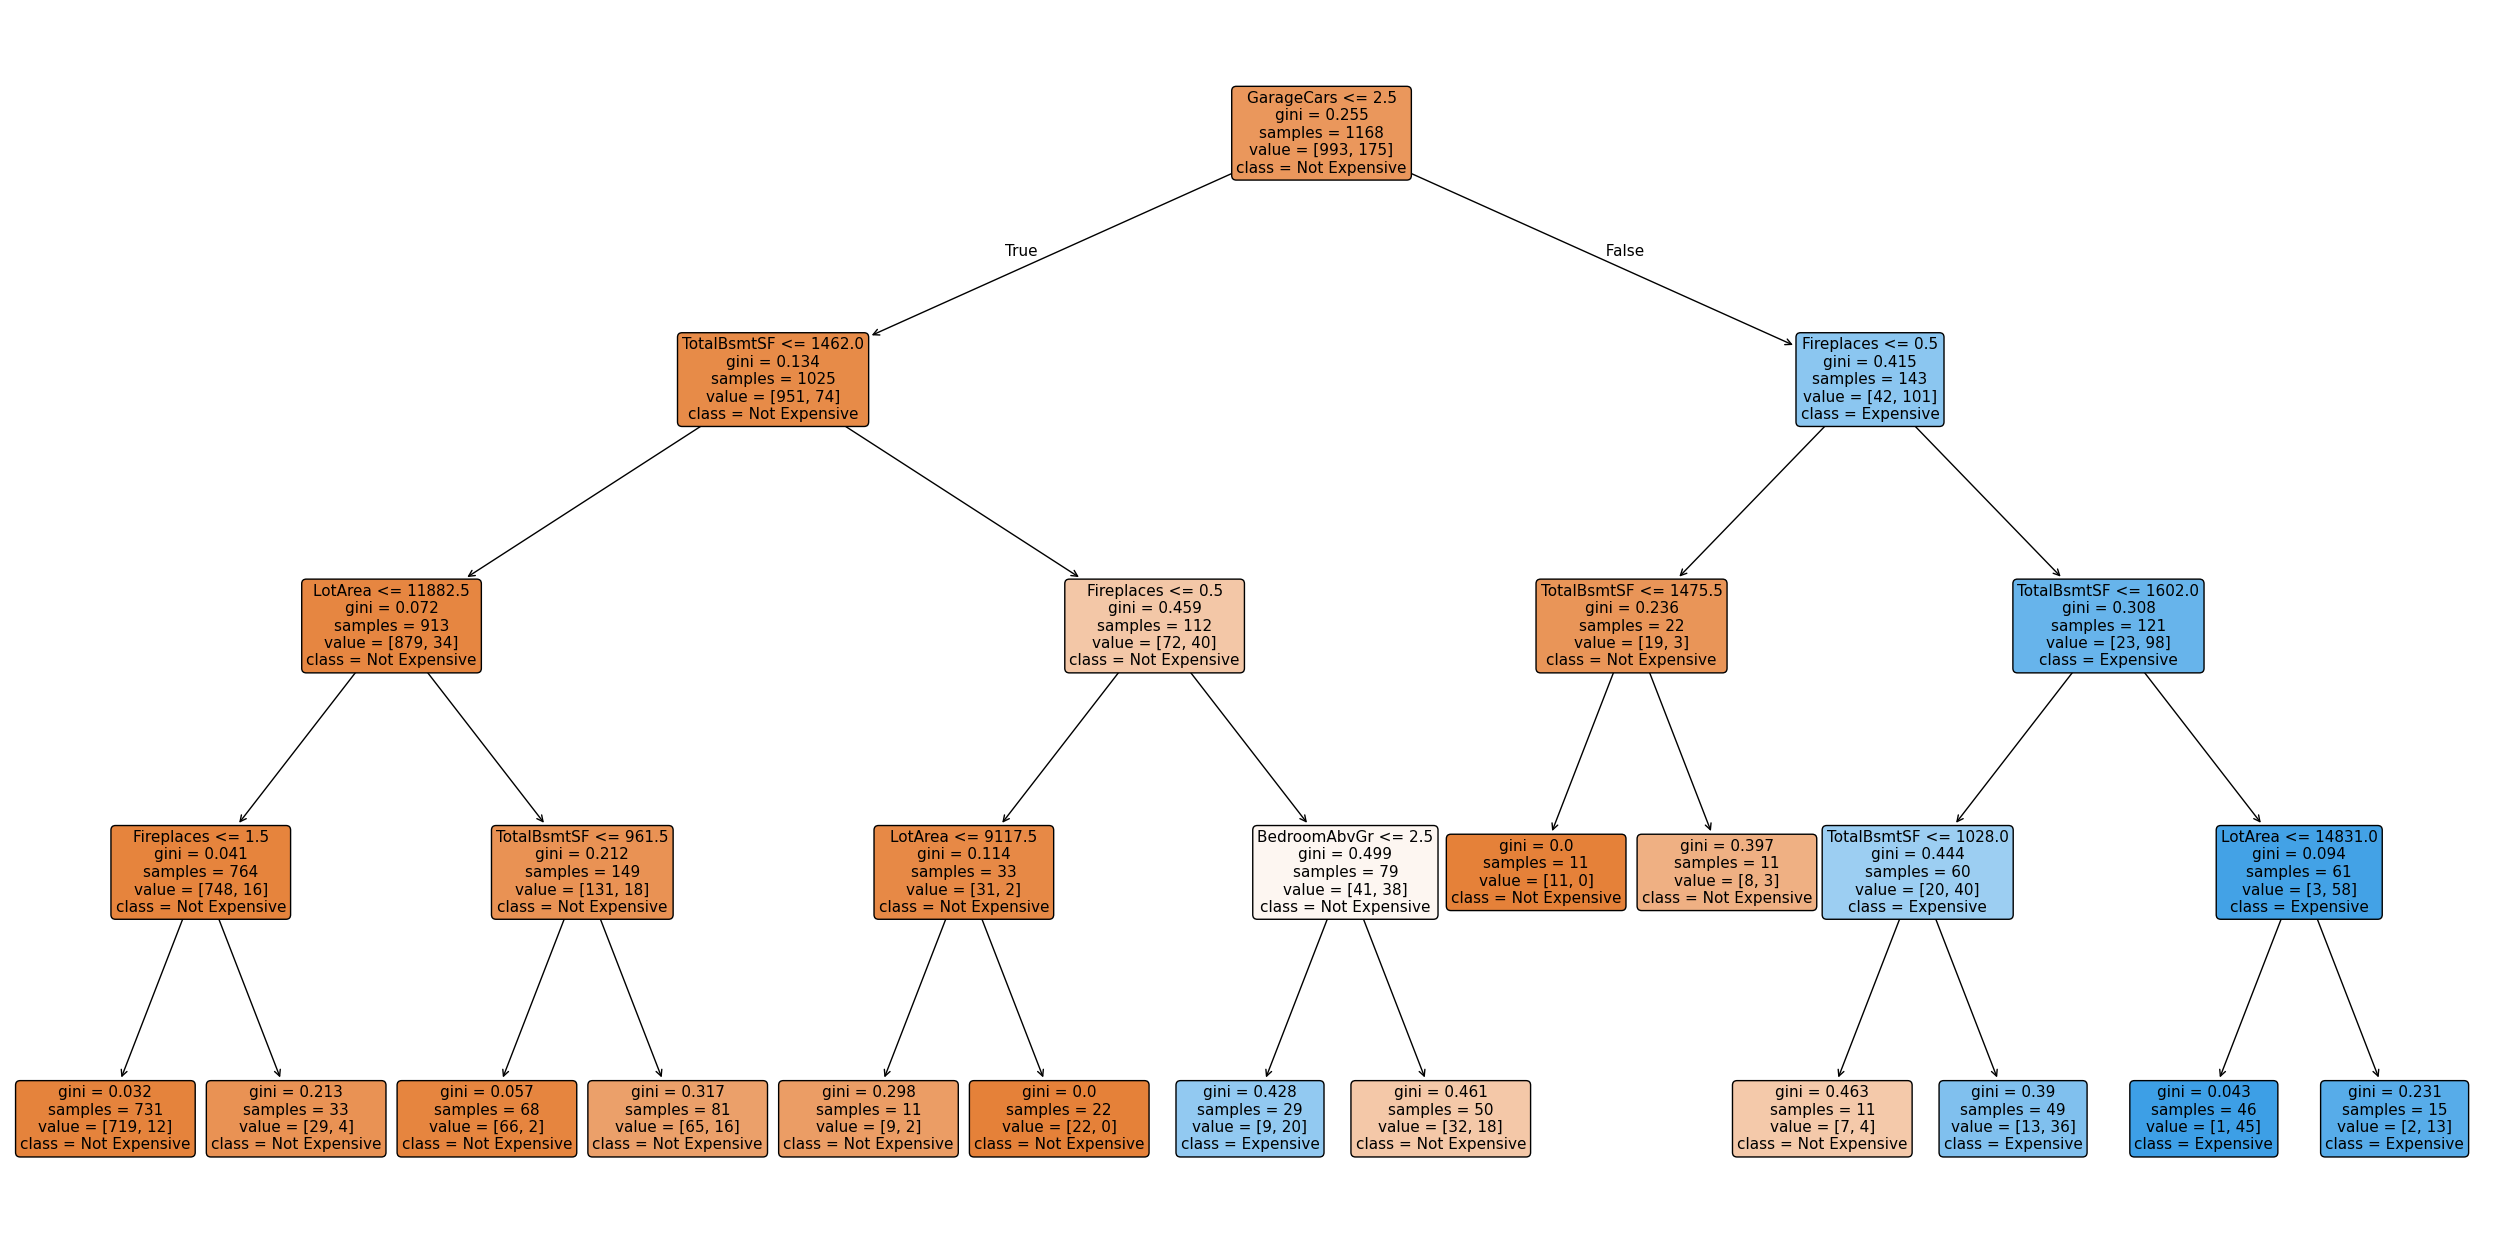

In [30]:
# 2. initialize the model (optional: give some parameters)
my_tree_prune = DecisionTreeClassifier(max_depth=4,
                                 min_samples_leaf=10
                                )

# 3. fit the model to the train data
my_tree_prune.fit(X = X_imputed_prune_train,
            y = y_prune_train)

plt.figure(figsize=(32, 16))
plot_tree(
    my_tree_prune,
    filled=True,
    rounded=True,
    class_names=['Not Expensive','Expensive'],
    feature_names=X.columns
    );

In [31]:
#create a prediction on your train data
y_pruned_pred = my_tree_prune.predict(X_imputed_prune_train)

In [32]:
# Accuracy for train data
accuracy_score(y_true = y_prune_train, 
               y_pred = y_pruned_pred)

0.9263698630136986

In [33]:
# Prediction for the test data
y_pruned_pred_test = my_tree_prune.predict(X_prune_imputed_test)

In [34]:
#Accuracy for the test data
accuracy_score(y_true = y_prune_test,
                y_pred = y_pruned_pred_test)

0.9315068493150684

The accuracy for the train data is now lower than before, but it is closer to the results for the test sets. The pruning worked, but there is room for improvement.

## 4.&nbsp; Use GridSearchCV to find the best parameters of the model

So far, we tuned the hyperparameters of the decision tree manually. This is not ideal, for two reasons:

- It's not efficient in terms of quickly finding the best combination of parameters.
- If we keep checking the performance on the test set over and over again, we might end up creating a model that fits that particular test set, but does not generalize as well with new data. Test sets are meant to reamain unseen until the very last moment of ML development —we have been cheating a bit!

Grid Search Cross Validation solves both issues.

* Check the docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [35]:
X_imputed_GSCV_train = X_imputed_train.copy()
y_GSCV_train = y_train.copy()

In [36]:
X_imputed_GSCV_test = X_imputed_test.copy()
y_GSCV_test = y_test.copy()

In [37]:
# 1. initialize transformers & model without specifying the parameters
imputer_GSCV = SimpleImputer()
dtree_GSCV = DecisionTreeClassifier()

In [38]:
from sklearn.pipeline import make_pipeline

In [39]:
# 2. Create a pipeline
pipe_GSCV = make_pipeline(imputer_GSCV, dtree_GSCV).set_output(transform='pandas')

In [40]:
pipe_GSCV

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

To define the parameter grid for cross validation, we need to create a dictionary, where:

- The keys are the name of the pipeline step, followed by two underscores and the name of the parameter we want to tune.
- The values are lists (or "ranges") with all the values we want to try for each parameter.

In [41]:
param_grid = {
    'decisiontreeclassifier__max_depth': range(2, 12),
    'decisiontreeclassifier__min_samples_leaf': range(3, 10, 2),
    'decisiontreeclassifier__min_samples_split': range(3, 40, 5),
    'decisiontreeclassifier__criterion':['gini', 'entropy']
    }

When defining the cross validation, we want to pass our pipeline (`pipe`), our parameter grid (`param_grid`) and the number of folds (an arbitrary number, usually 5 or 10). We can also define the parameter `verbose` if we want to recieve a bit more info about the CV task.

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
search = GridSearchCV(pipe_GSCV, # you have defined this beforehand
                      param_grid, # your parameter grid
                      cv=5, # the value for K in K-fold Cross Validation
                      scoring='accuracy', # the performance metric to use,
                      verbose=1) # we want informative outputs during the training process, try changing it to 2 and see what happens

Then, we fit our "search" to the training data (`X` and `y`):

In [44]:
search.fit(X_imputed_GSCV_train, y_GSCV_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(2, 12),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 10, 2),
                         'decisiontreeclassifier__min_samples_split': range(3, 40, 5)},
             scoring='accuracy', verbose=1)

Explore the best parameters and the best score achieved with your cross validation:

In [45]:
search.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 5,
 'decisiontreeclassifier__min_samples_split': 28}

In [46]:
# the mean cross-validated score of the best estimator
search.best_score_

np.float64(0.9238105718792413)

In [47]:
# training accuracy
y_train_pred_GSCV = search.predict(X_imputed_GSCV_train)

accuracy_score(y_GSCV_train, y_train_pred_GSCV)

0.934931506849315

In [48]:
# testing accuracy
y_test_pred_GSCV = search.predict(X_imputed_GSCV_test)

accuracy_score(y_GSCV_test, y_test_pred_GSCV)

0.9246575342465754

Let's plot the Decision Tree:

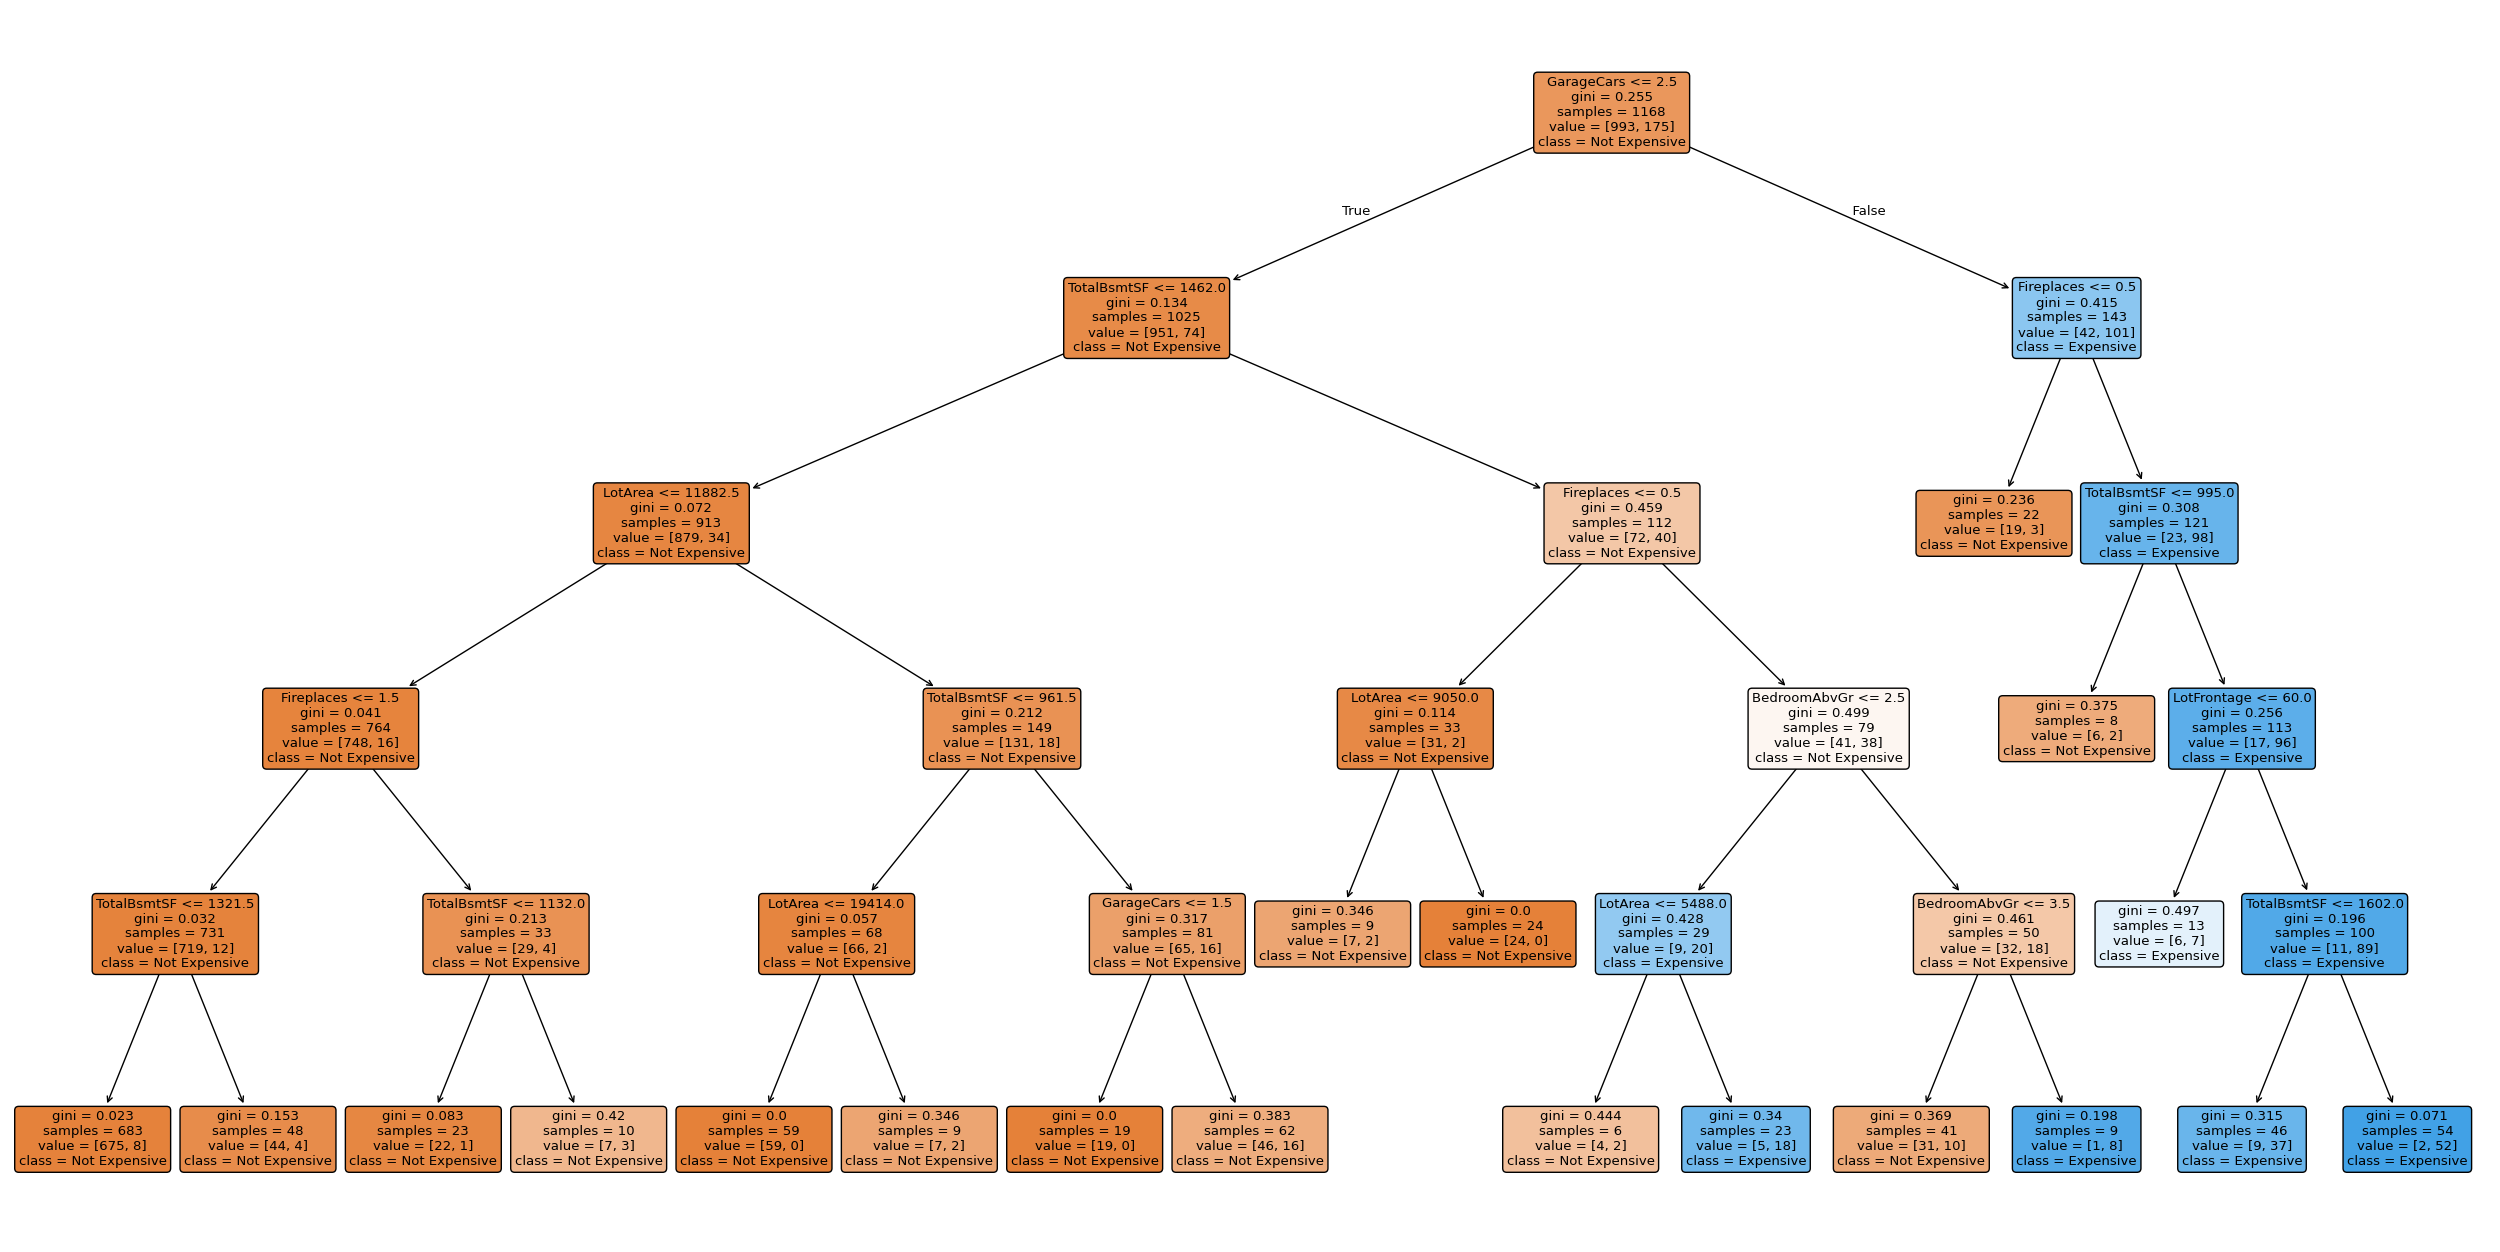

In [49]:
# your code here
# 2. initialize the model (optional: give some parameters)
my_tree_best_params = DecisionTreeClassifier(max_depth=5,
                                 min_samples_leaf=5,
                                 min_samples_split= 28,
                                 criterion='gini'
                                )

# 3. fit the model to the train data
my_tree_best_params.fit(X = X_imputed_GSCV_train,
            y = y_GSCV_train)

plt.figure(figsize=(32, 16))
plot_tree(
    my_tree_best_params,
    filled=True,
    rounded=True,
    class_names=['Not Expensive','Expensive'],
    feature_names=X.columns
    );

## 5.&nbsp; Pipeline creation

Now we learn how to use Scikit-Learn Pipelines. They will not increase the performance of your model. However, they are a necessary tool to compress all the steps in the data preparation & modelling phases into a single one. This will become very relevant as we move forward and keep adding more steps.

Check the docs: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

In [50]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

In [51]:
X_imputed_pipe_train = X_imputed_train.copy()
y_pipe_train = y_train.copy()
X_imputed_pipe_test = X_imputed_test.copy()
y_pipe_test = y_test.copy()

### 5.1.&nbsp; Initialize transformer and model

In [52]:
imputer_pipe = SimpleImputer(strategy="median")
dtree_pipe = DecisionTreeClassifier(max_depth=5,
                                    min_samples_leaf=5,
                                    min_samples_split=28,
                                    criterion='gini',
                                    random_state=42)

### 5.2.&nbsp; Create a pipeline

In [53]:
pipe = make_pipeline(imputer_pipe, dtree_pipe).set_output(transform='pandas')

### 5.3.&nbsp; Fit the pipeline to the training data

In [54]:
pipe.fit(X_imputed_pipe_train, y_pipe_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=28,
                                        random_state=42))])

If you want pipe steps presented like text:

In [55]:
from sklearn import set_config

set_config(display="text")
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=28,
                                        random_state=42))])

To switch back to diagram:

In [56]:
set_config(display="diagram")
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=28,
                                        random_state=42))])

### 5.4.&nbsp; Use the pipeline to make predictions

In [57]:
pipe.predict(X_imputed_pipe_test)

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Now, the object `pipe` can take (almost) raw data as input and output predictions. We no longer need to impute missing values and use the model to make predictions in separate steps.

## 6.&nbsp; Use GridSearchCV to find the best parameters of the pipeline

Add a scaler to the pipeline, and use GridSearchCV to tune the parameters of the scaler, as well as the parameters of the imputer and the decision tree.

This shows how Grid Search Cross Validation can be used to not only tune the parameters of the model but also the parameters of all the transformers in a pipeline, thus helping us find the best preprocessing strategy for our data.

In [58]:
X_pipeline_train = X_imputed_train.copy()
y_pipeline_train = y_train.copy()
X_pipeline_test = X_imputed_test.copy()
y_pipeline_test = y_test.copy()

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
# initialize transformers & model
imputer_pipeline = SimpleImputer()
scaler_pipeline = StandardScaler()
dtree_pipeline = DecisionTreeClassifier()

In [61]:
# create the pipeline
pipe_GridSearchCV = make_pipeline(imputer_pipeline,
                     scaler_pipeline,
                     dtree_pipeline).set_output(transform='pandas')

We can see the steps in the pipeline (note that they have been given names: `simpleimputer` and `decisiontreeclassifier`. we will use these names when defining the parameter grid for the cross validation)

In [62]:
pipe_GridSearchCV

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [63]:
# create parameter grid
param_grid_GridSearchCV = {
    "simpleimputer__strategy":["mean", "median"],
    "standardscaler__with_mean":[True, False],
    "standardscaler__with_std":[True, False],
    "decisiontreeclassifier__max_depth": range(2, 14),
    "decisiontreeclassifier__min_samples_leaf": range(3, 10),
    "decisiontreeclassifier__criterion":["gini", "entropy"]
}

In [64]:
# define cross validation
search_GridSearchCV = GridSearchCV(pipe_GridSearchCV,
                      param_grid_GridSearchCV,
                      cv=10,
                      verbose=1)

In [65]:
# fit
search_GridSearchCV.fit(X_pipeline_train, y_pipeline_train)

Fitting 10 folds for each of 1344 candidates, totalling 13440 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(2, 14),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 10),
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]},
             verbose=1)

In [66]:
# cross validation average accuracy
search_GridSearchCV.best_score_

np.float64(0.9272399056881817)

In [67]:
# best parameters
search_GridSearchCV.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 6,
 'decisiontreeclassifier__min_samples_leaf': 6,
 'simpleimputer__strategy': 'mean',
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True}

In [68]:
# training accuracy
y_train_pred_pipeline = search.predict(X_pipeline_train)

accuracy_score(y_pipeline_train, y_train_pred_pipeline)

0.934931506849315

In [69]:
# testing accuracy
y_test_pred_pipeline = search.predict(X_pipeline_test)

accuracy_score(y_pipeline_test, y_test_pred_pipeline)

0.9246575342465754

Let's plot the Decision Tree:

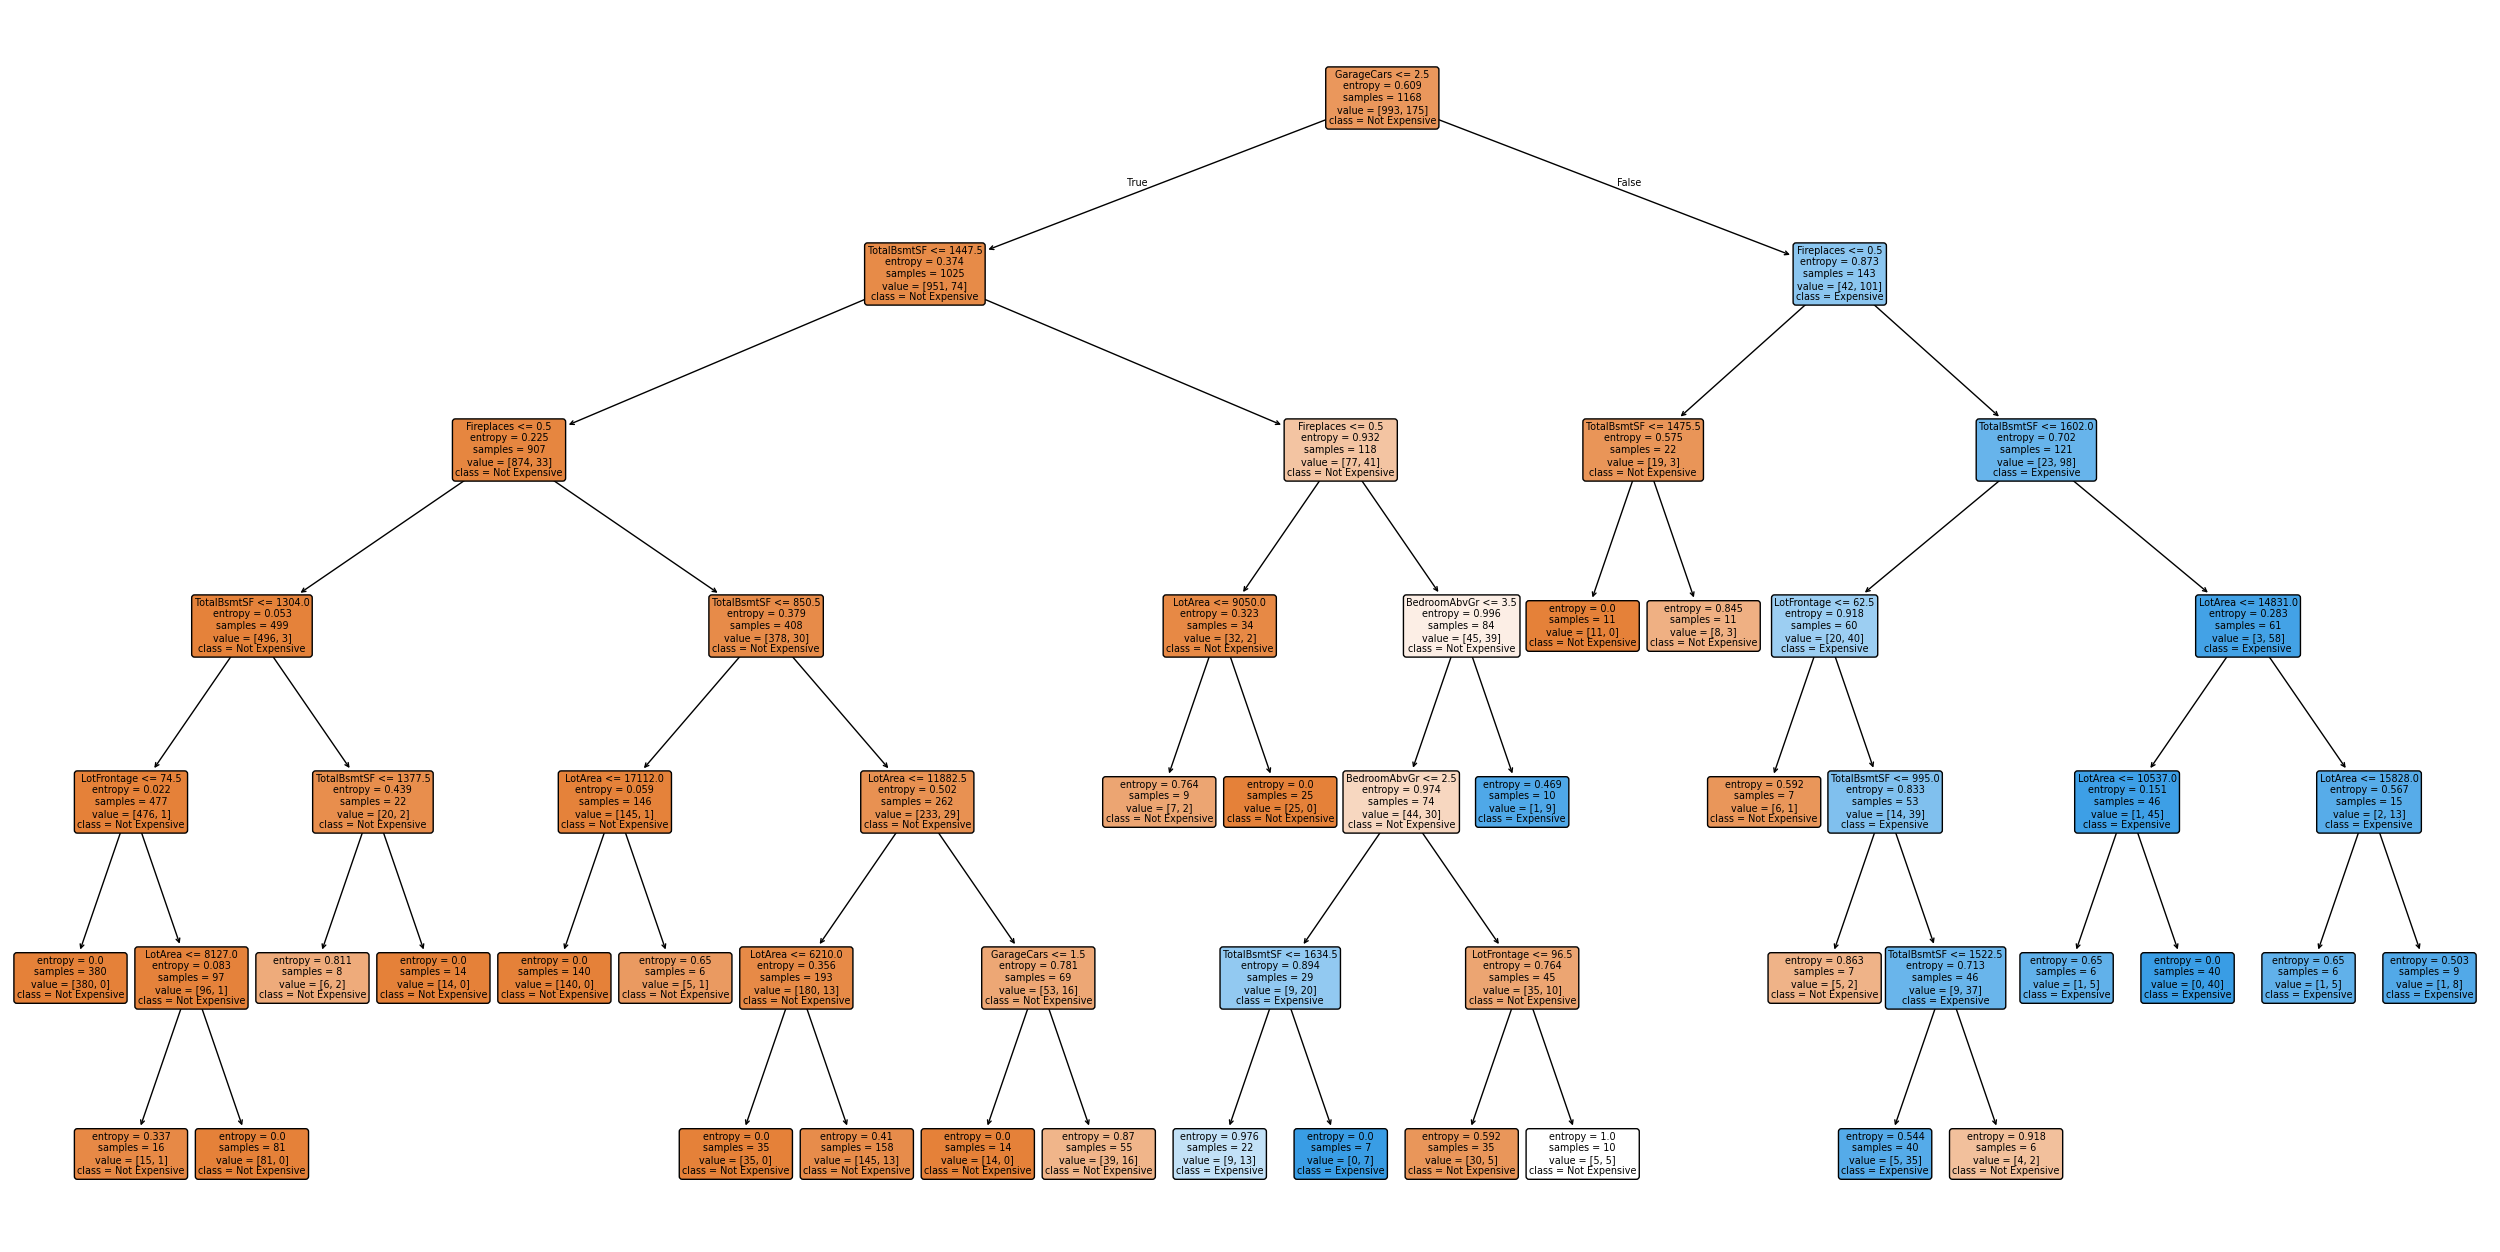

In [70]:
# your code here
# 2. initialize the model (optional: give some parameters)
pipeline_tree_best_params = DecisionTreeClassifier(max_depth=6,
                                 min_samples_leaf=6,
                                 criterion='entropy'
                                )

# 3. fit the model to the train data
pipeline_tree_best_params.fit(X = X_pipeline_train,
            y = y_pipeline_train)

plt.figure(figsize=(32, 16))
plot_tree(
    pipeline_tree_best_params,
    filled=True,
    rounded=True,
    class_names=['Not Expensive','Expensive'],
    feature_names=X.columns
    );